In [1]:
import math, random, pickle, os, copy, itertools, sys
import torch, logging, scipy.io
import numpy as np
import pandas as pd
from numpy import random
from datetime import datetime
import matplotlib.pyplot as plt
from collections.abc import Iterable

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from city_pv_uni_modal import CityPV_UniModal
from city_pv_multi_modal import CityPV_MultiModal
from utils_pv import get_available_modules, get_available_inverters, visualize_pv, visualize_env
from samples.data_sim import PVDataset

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)


# Uni-Modal Heterogeneous Clients Distribution
All clients are located in Lausanne and share the same latitude and longitude


Difference among clients in:
* PV cell orientation (tilt and azimuth)
* temperature and wind speed
* altitude from see level
* PV module and inverter technology
* Shaddows

## Effect of Shadows
* two clients
* a shadow appears for a while on the roof of each house
* everything same except the shadow timing

[INFO] generating data for Lausanne
[INFO] generating data for Lausanne

 3 households at Lausanne Lausanne - tilt_std: 0.0, az_std: 0.0, weather_dev: 0.0, irrad_std: 0.0, altitude_dev: 0.0, same module_name, same inverter_name, 


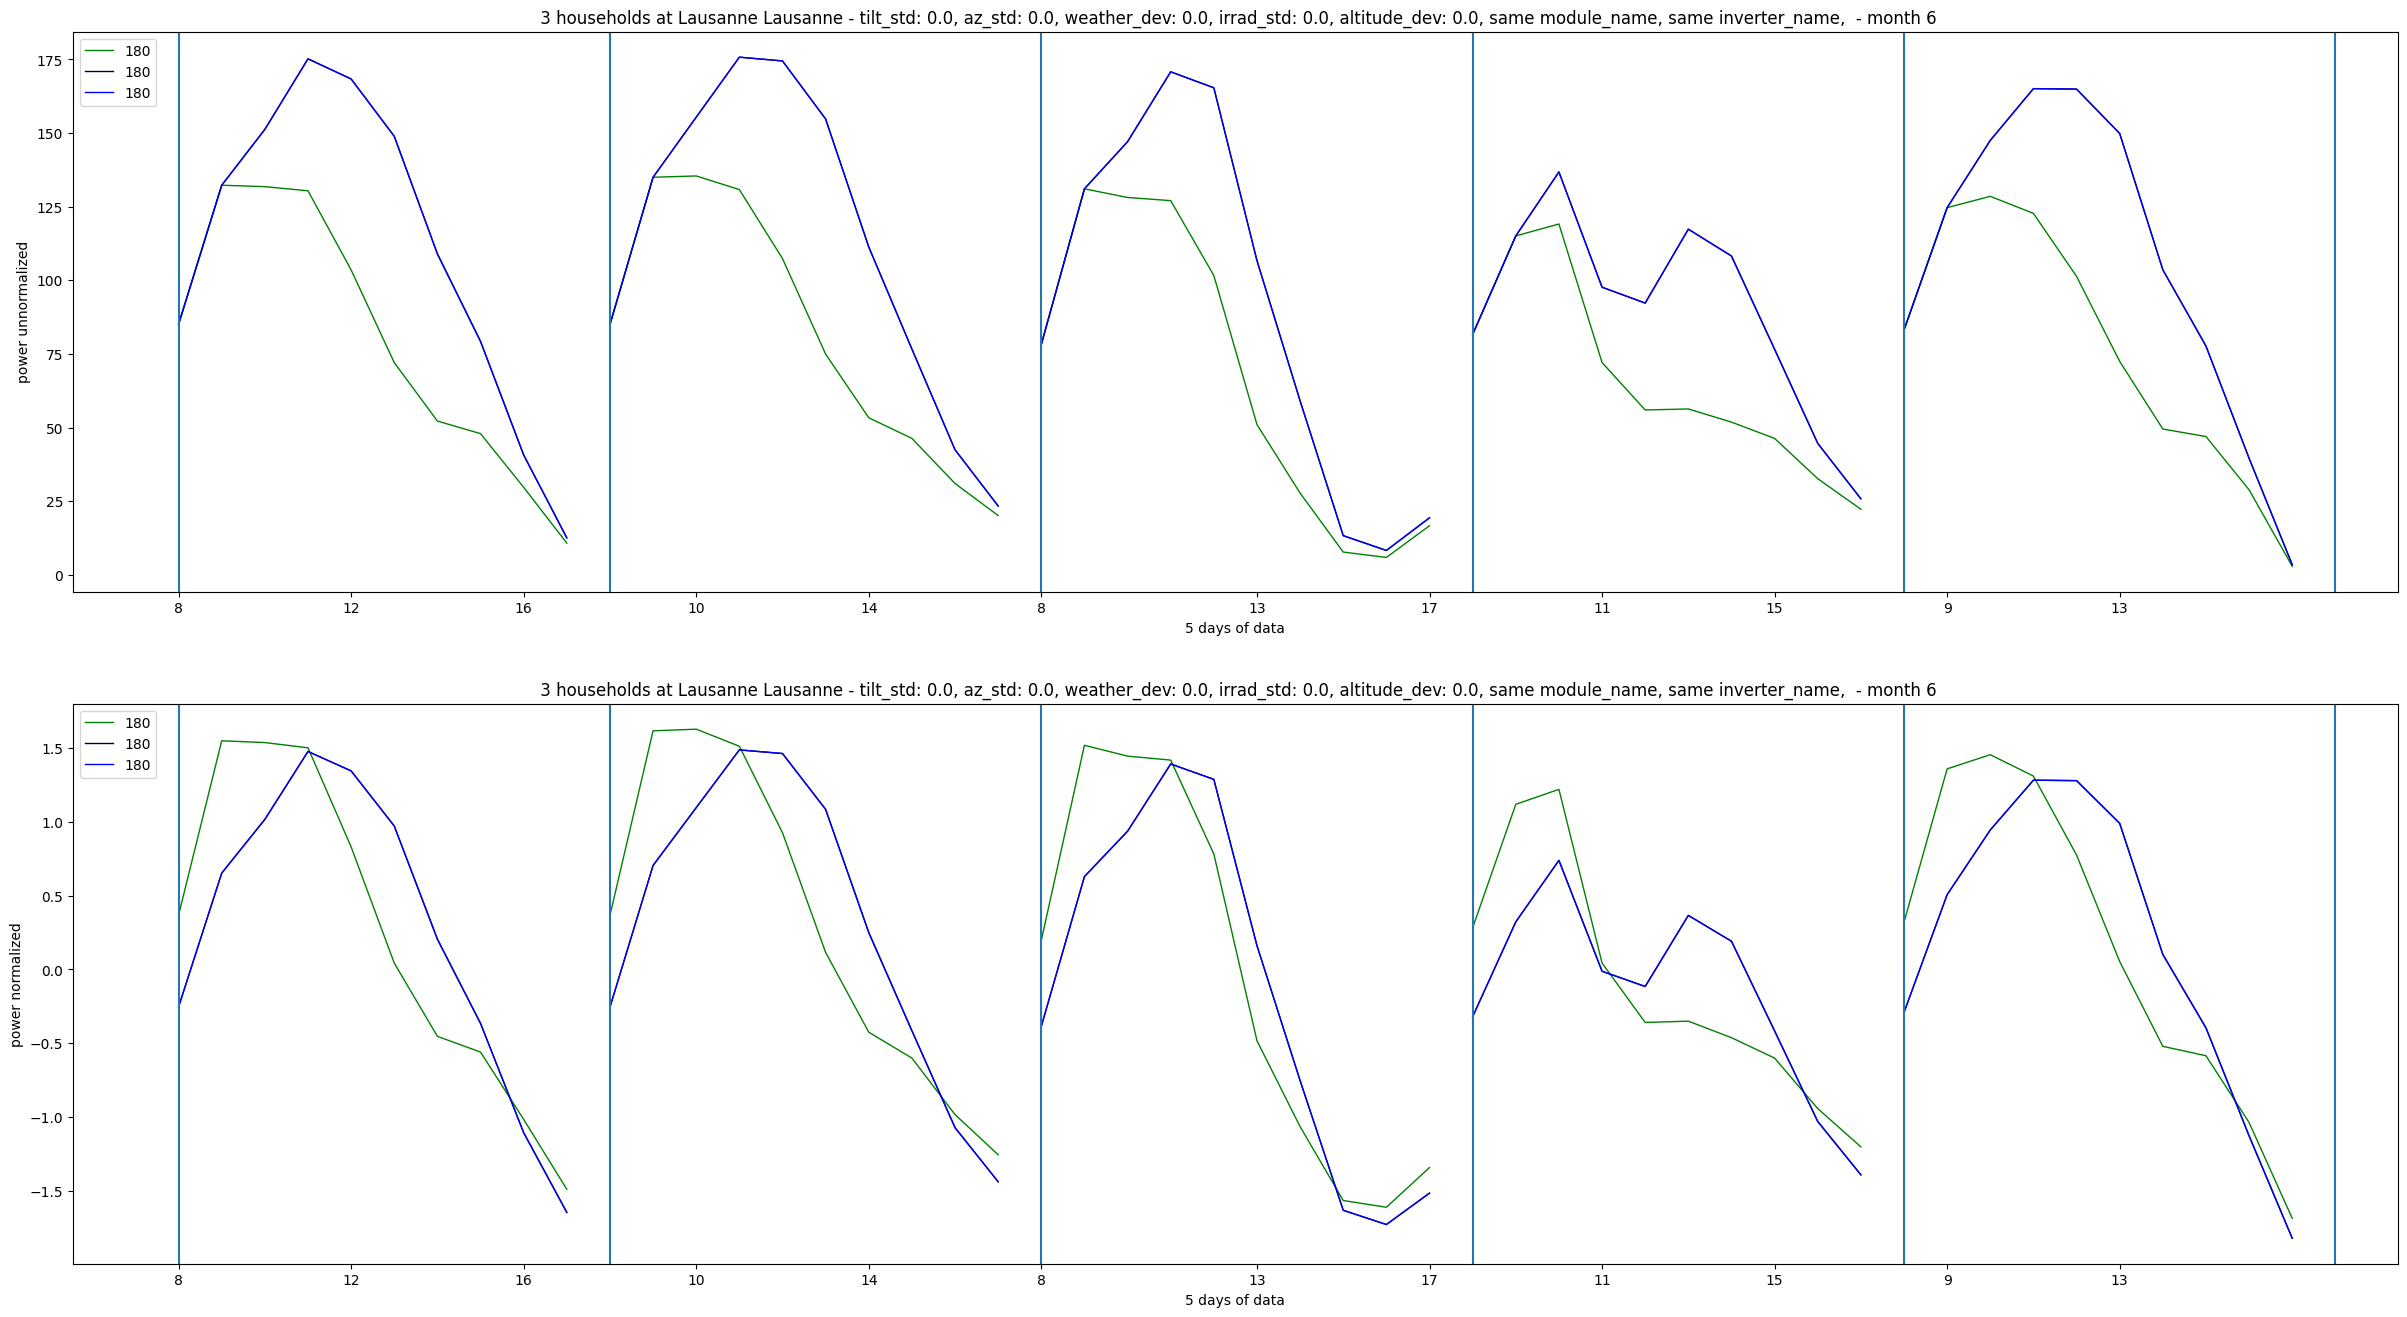

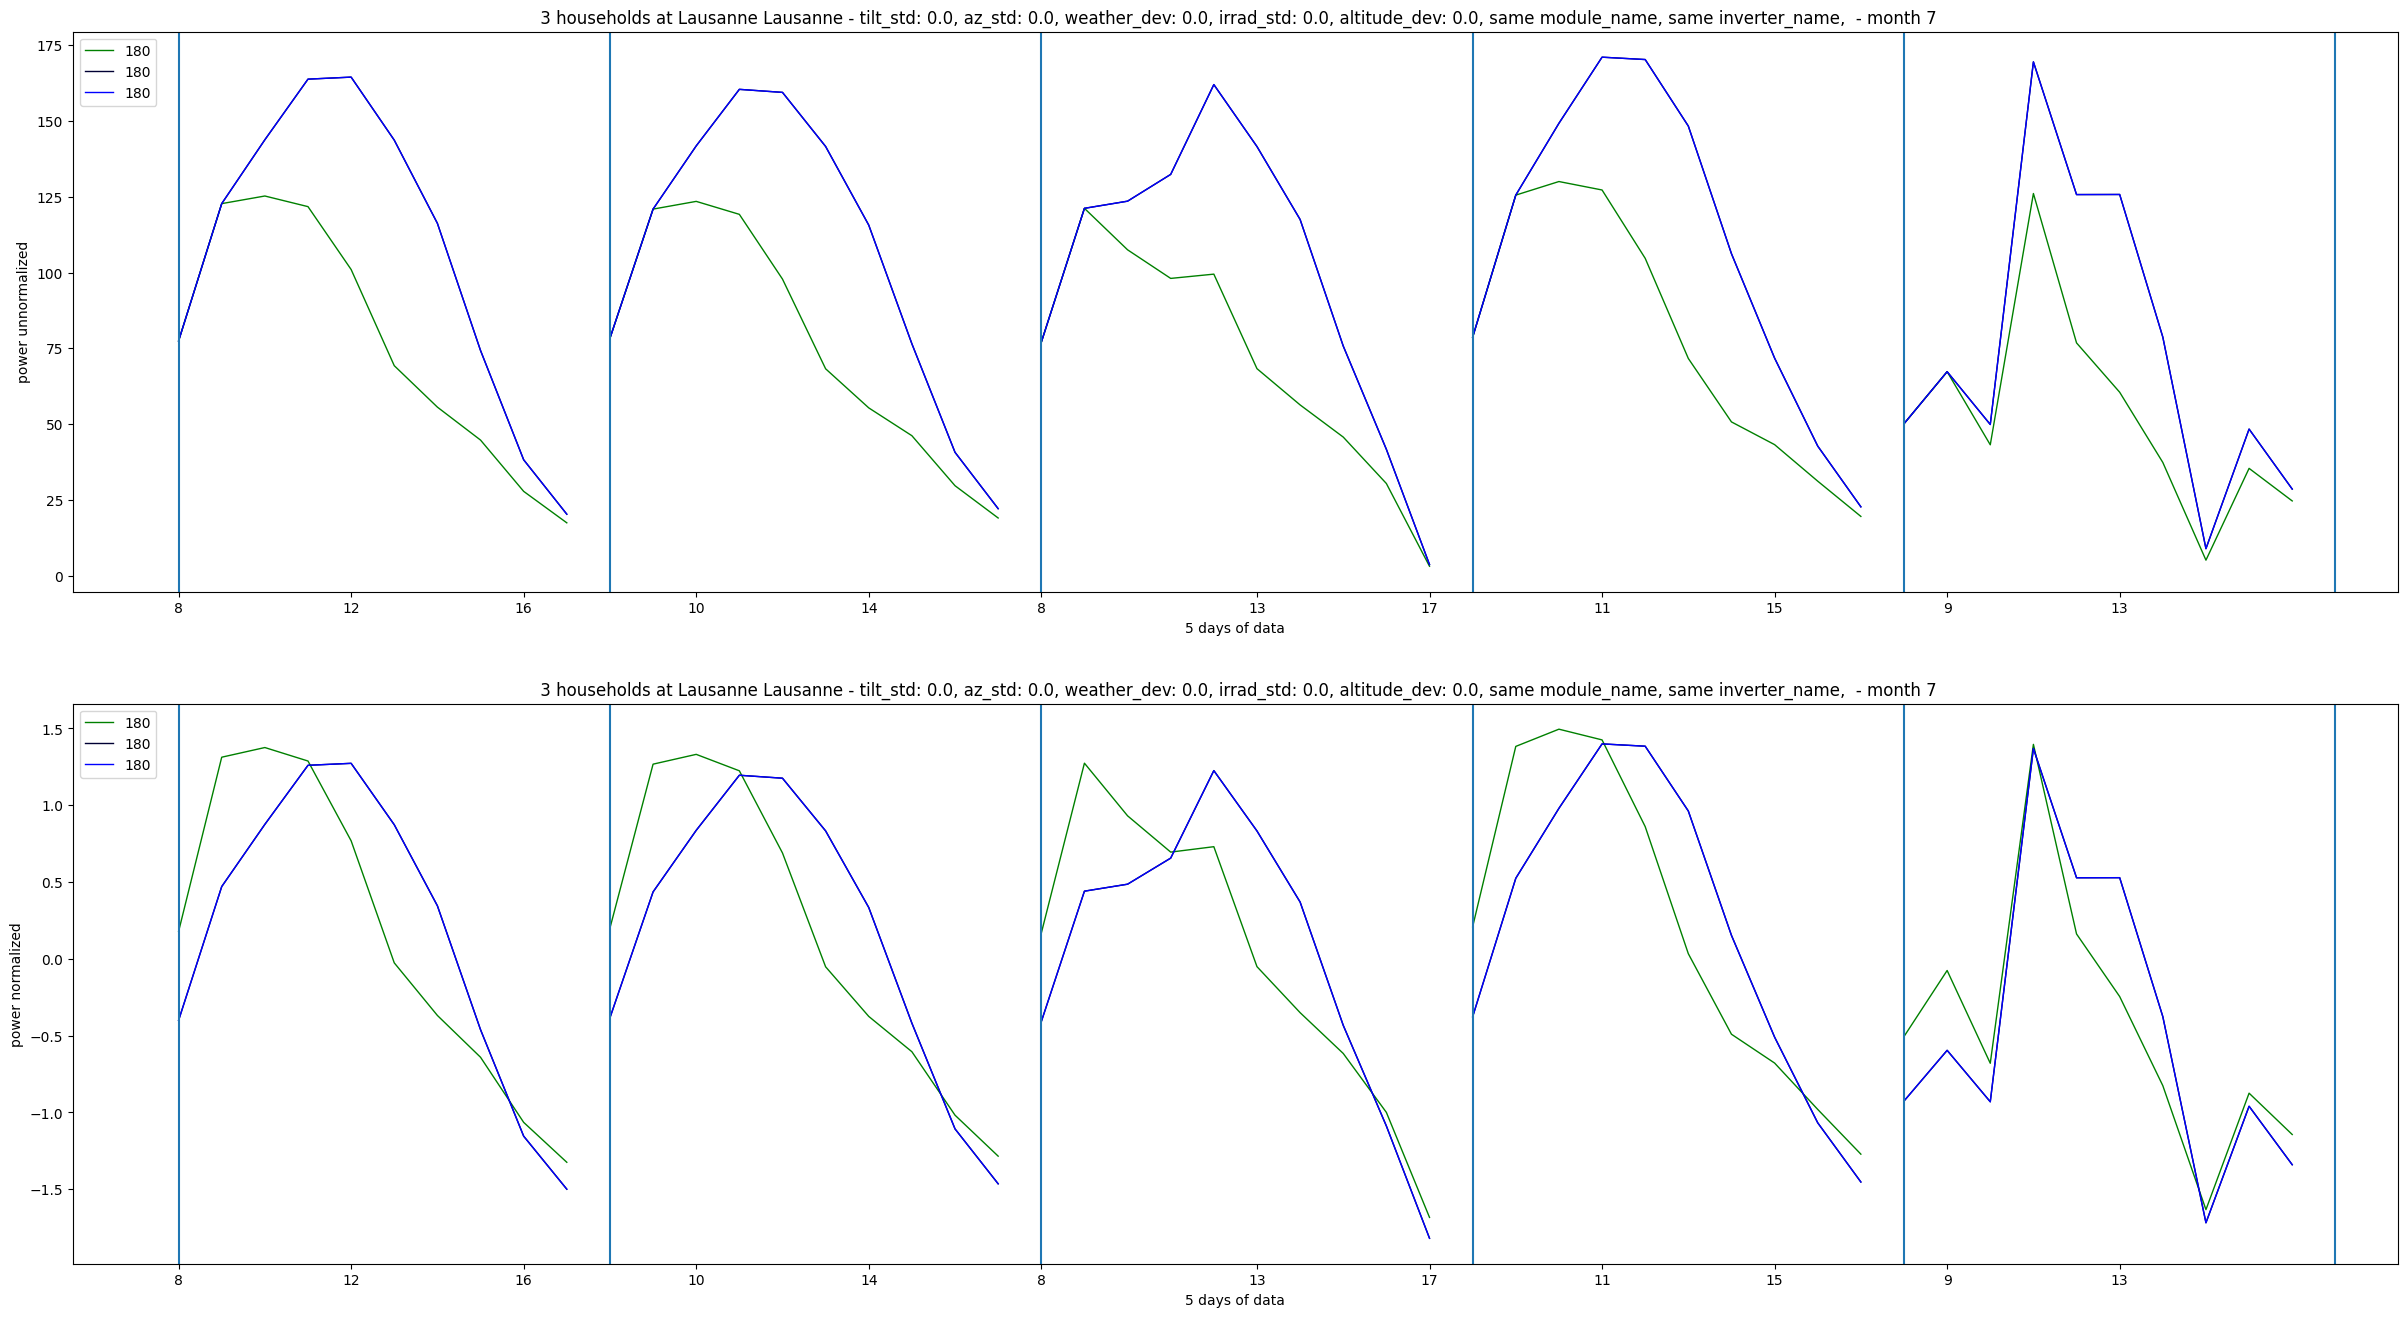

[{'st': 10, 'en': 17, 'peak_red': 0.5},
 {'st': None, 'en': None, 'peak_red': None},
 {'st': None, 'en': None, 'peak_red': None}]

In [2]:
num_clients=3
city_names = ['Lausanne', 'Lausanne']

env_dict = {'city_names':city_names,
        'num_clients': num_clients, 'num_clients_per_mode':[1,2],
        'tilt_std': 0, 'az_std': 0, 'weather_dev':0,
        'irrad_std':0, 'altitude_dev':0, 'shadow_peak_red':[0.5,1],
        'module_name': ['Canadian_Solar_CS5P_220M___2009_'],
        'inverter_name': ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
        'lags':[1], 'months':[6, 7], 'hours':np.arange(8, 18), 
        'train_scenarios':{'1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019}}}


env_dict = PVDataset(env_dict).generate_clients_data()
print('\n'+env_dict['info'])

visualize_env(env_dict, num_days=5, year=2018)
env_dict['clients_config']['shadows']



# Changing properties except azimuth and shaddow

[INFO] generating data for Lausanne

24 households at Lausanne - tilt_std: 5.0, az_std: 0.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 1.0, different module_name, different inverter_name, 


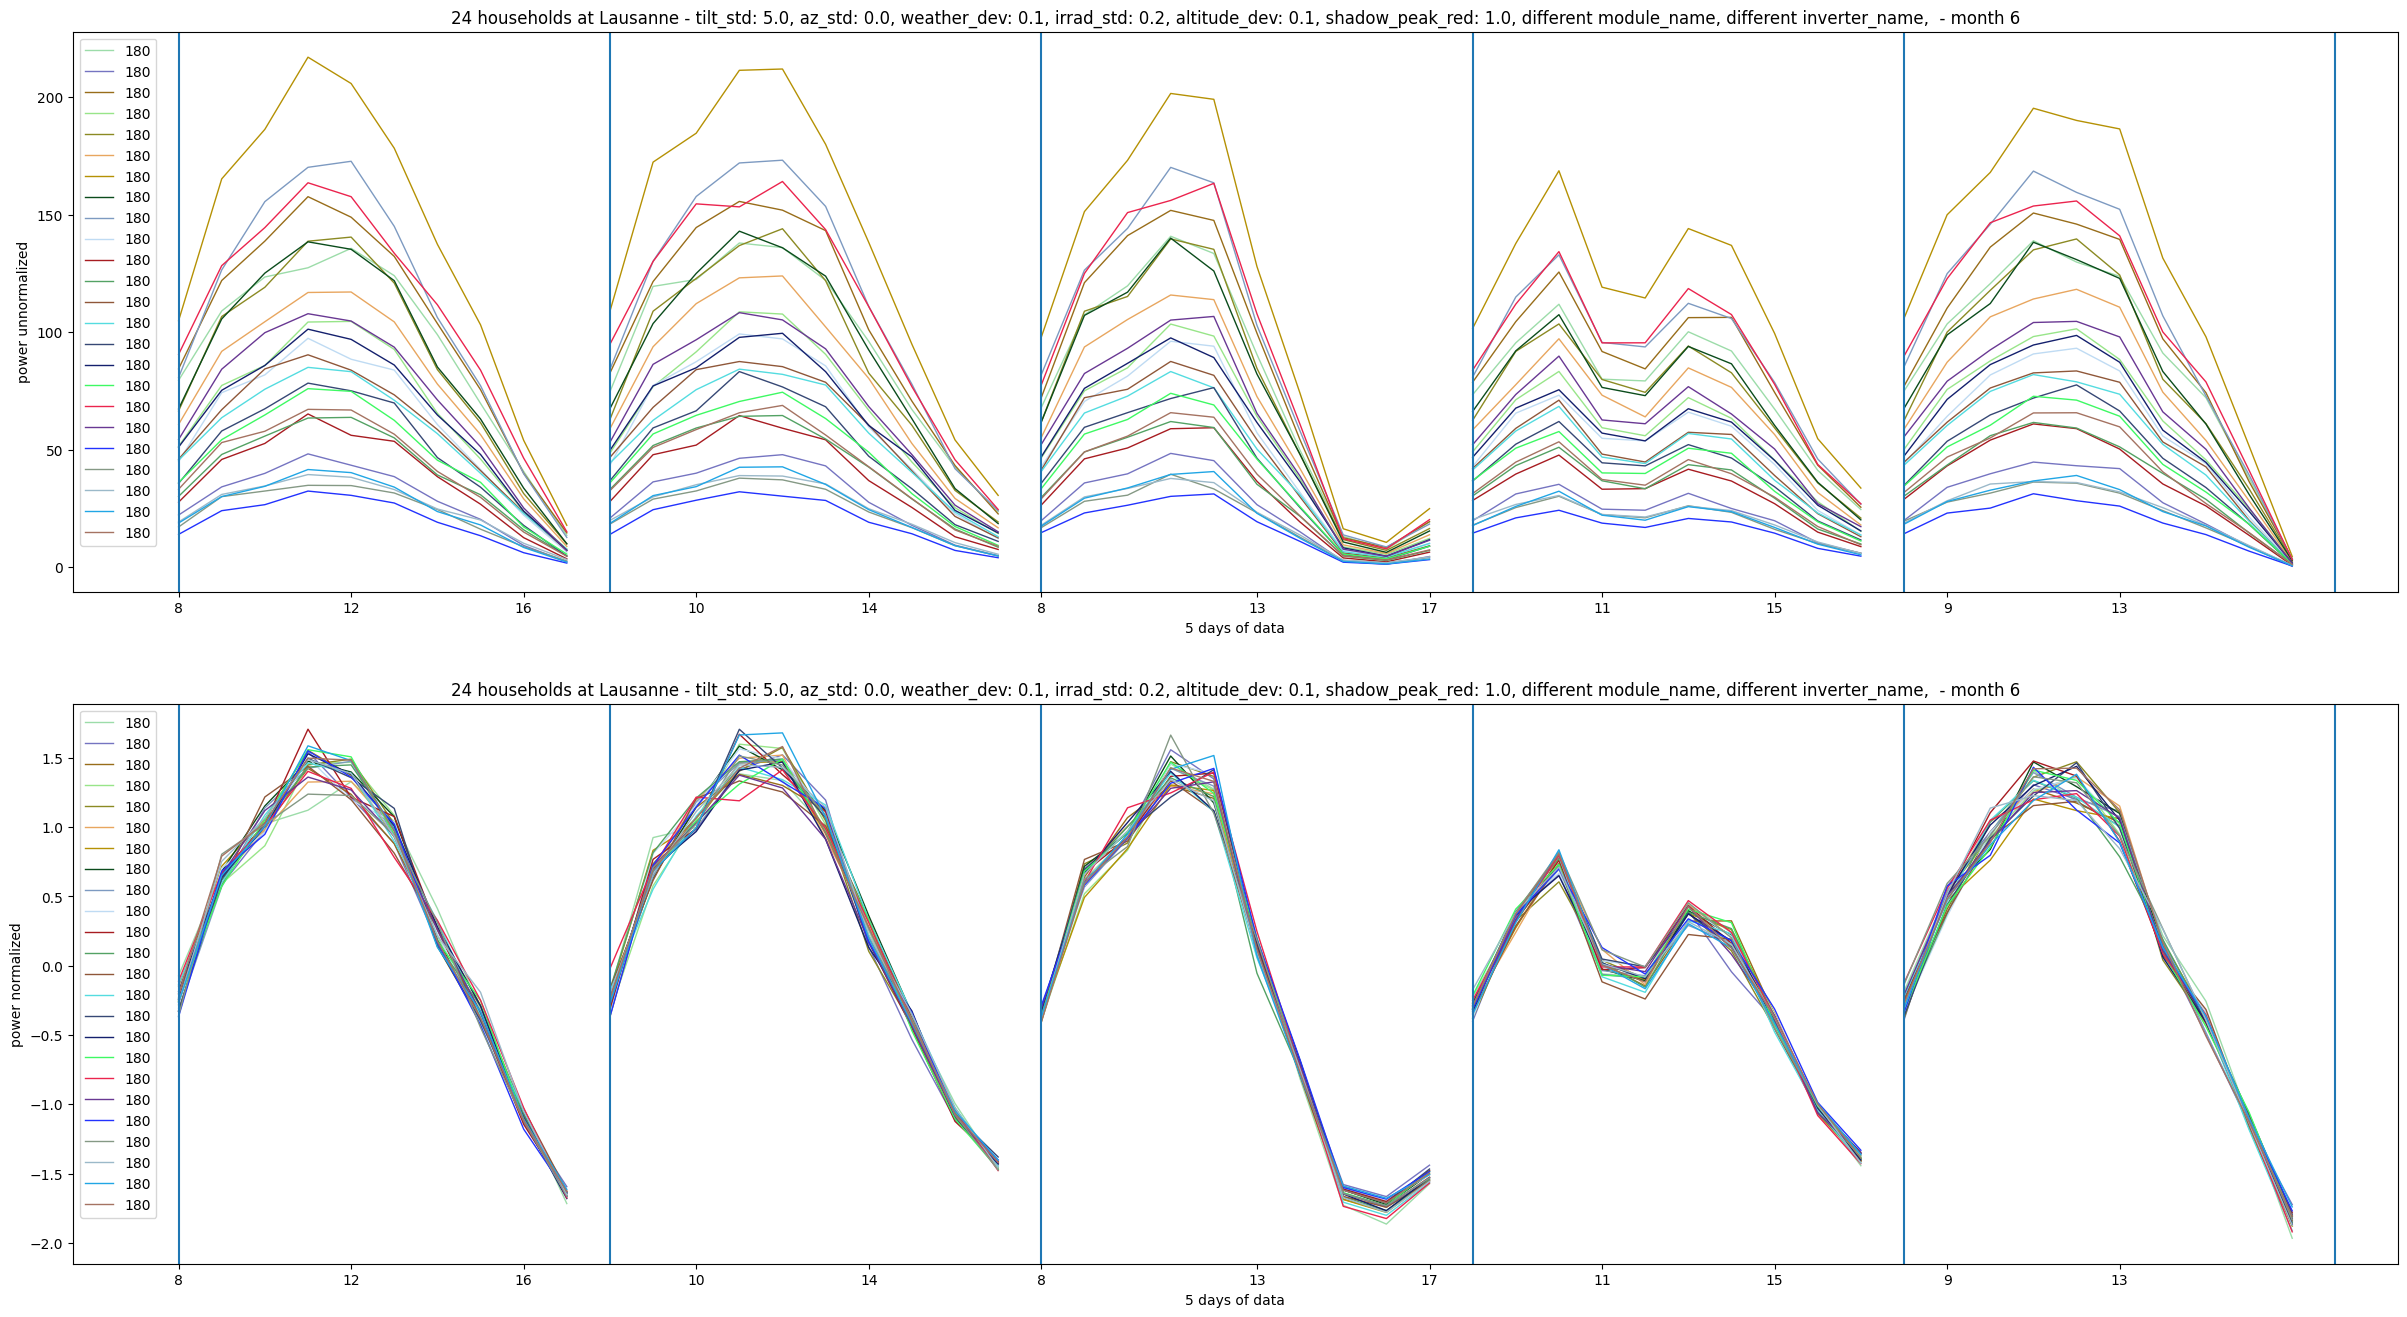

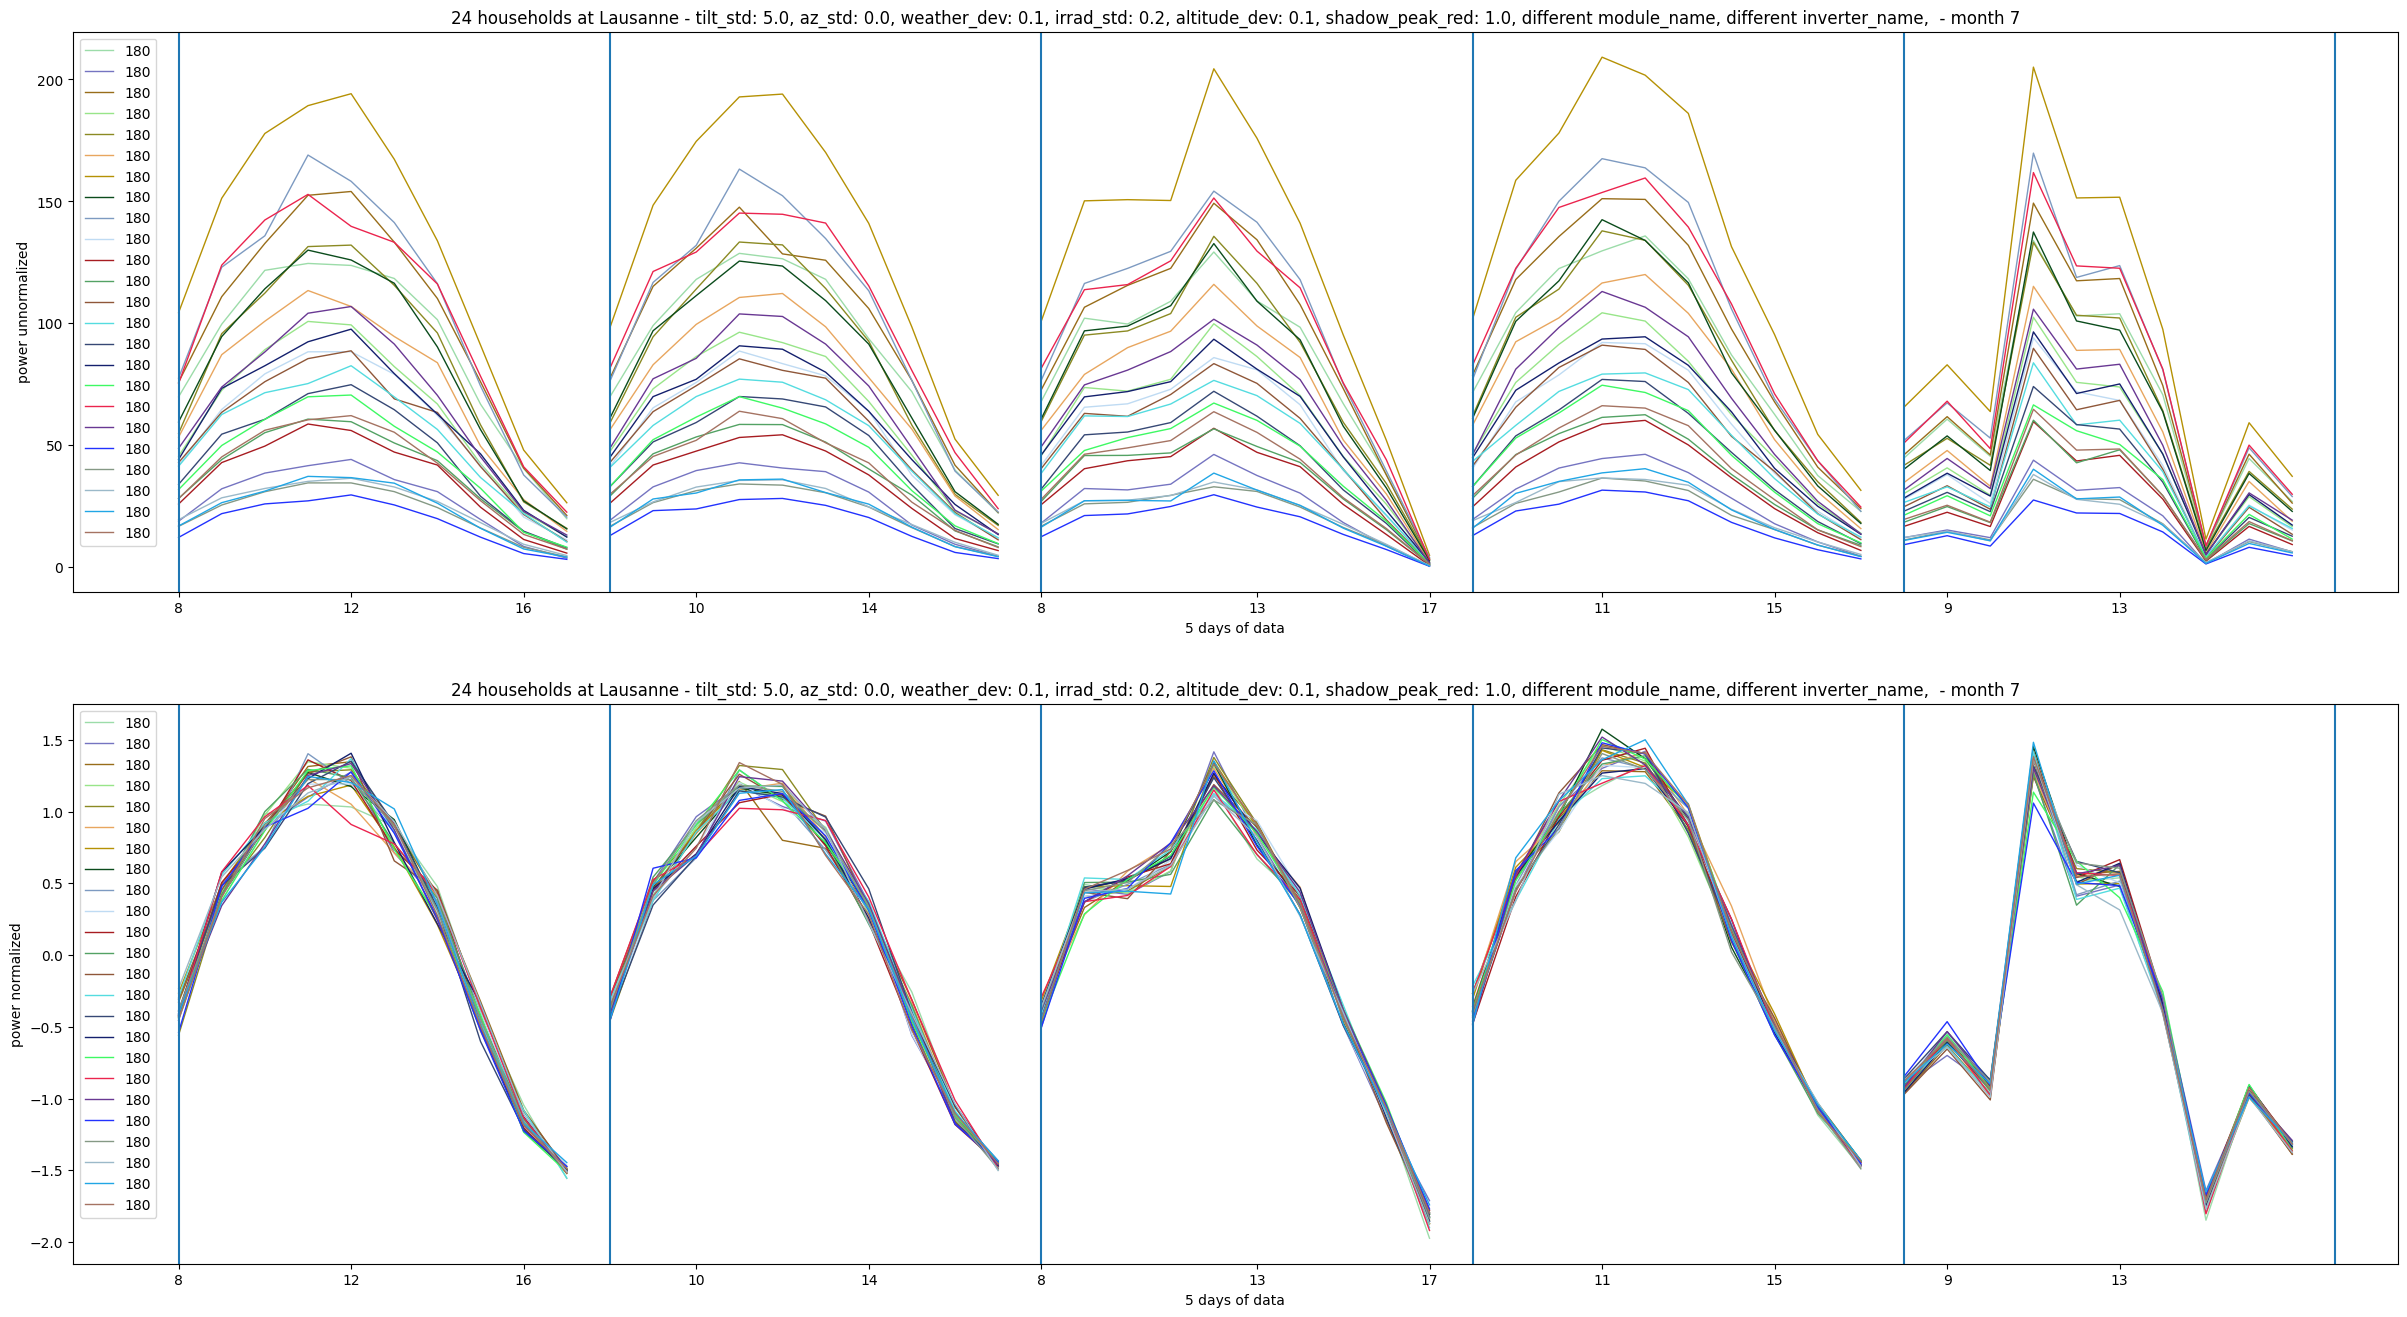

In [3]:
num_clients=24
city_names = ['Lausanne']
env_dict = {'city_names':city_names,
            'num_clients': num_clients, 'num_modes': len(city_names),
            'tilt_std': 5, 'az_std': 0, 'weather_dev':0.1,
            'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':1,
            'module_name': get_available_modules('sandia')[0:num_clients], #['Canadian_Solar_CS5P_220M___2009_'],
            'inverter_name': get_available_inverters('cec')[0:num_clients], # ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
            'lags':[1], 'months':[6, 7], 'hours':np.arange(8, 18), 
            'train_scenarios':{'1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019}}}

env_dict = PVDataset(env_dict).generate_clients_data()
print('\n'+env_dict['info'])

visualize_env(env_dict, num_days=5, year=2018)

# Change everything
This is the final env and is saved to be used later

# Train-Test Split
* only in June and July
* 15 years of data
* different training scenarios using 2 weeks, 1 year, 5 years, and 14 years of data for training between 2005-2018
* always test on June and July of 2019


[INFO] generating data for Lausanne
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
14y has 8540 train and 610 validation samples


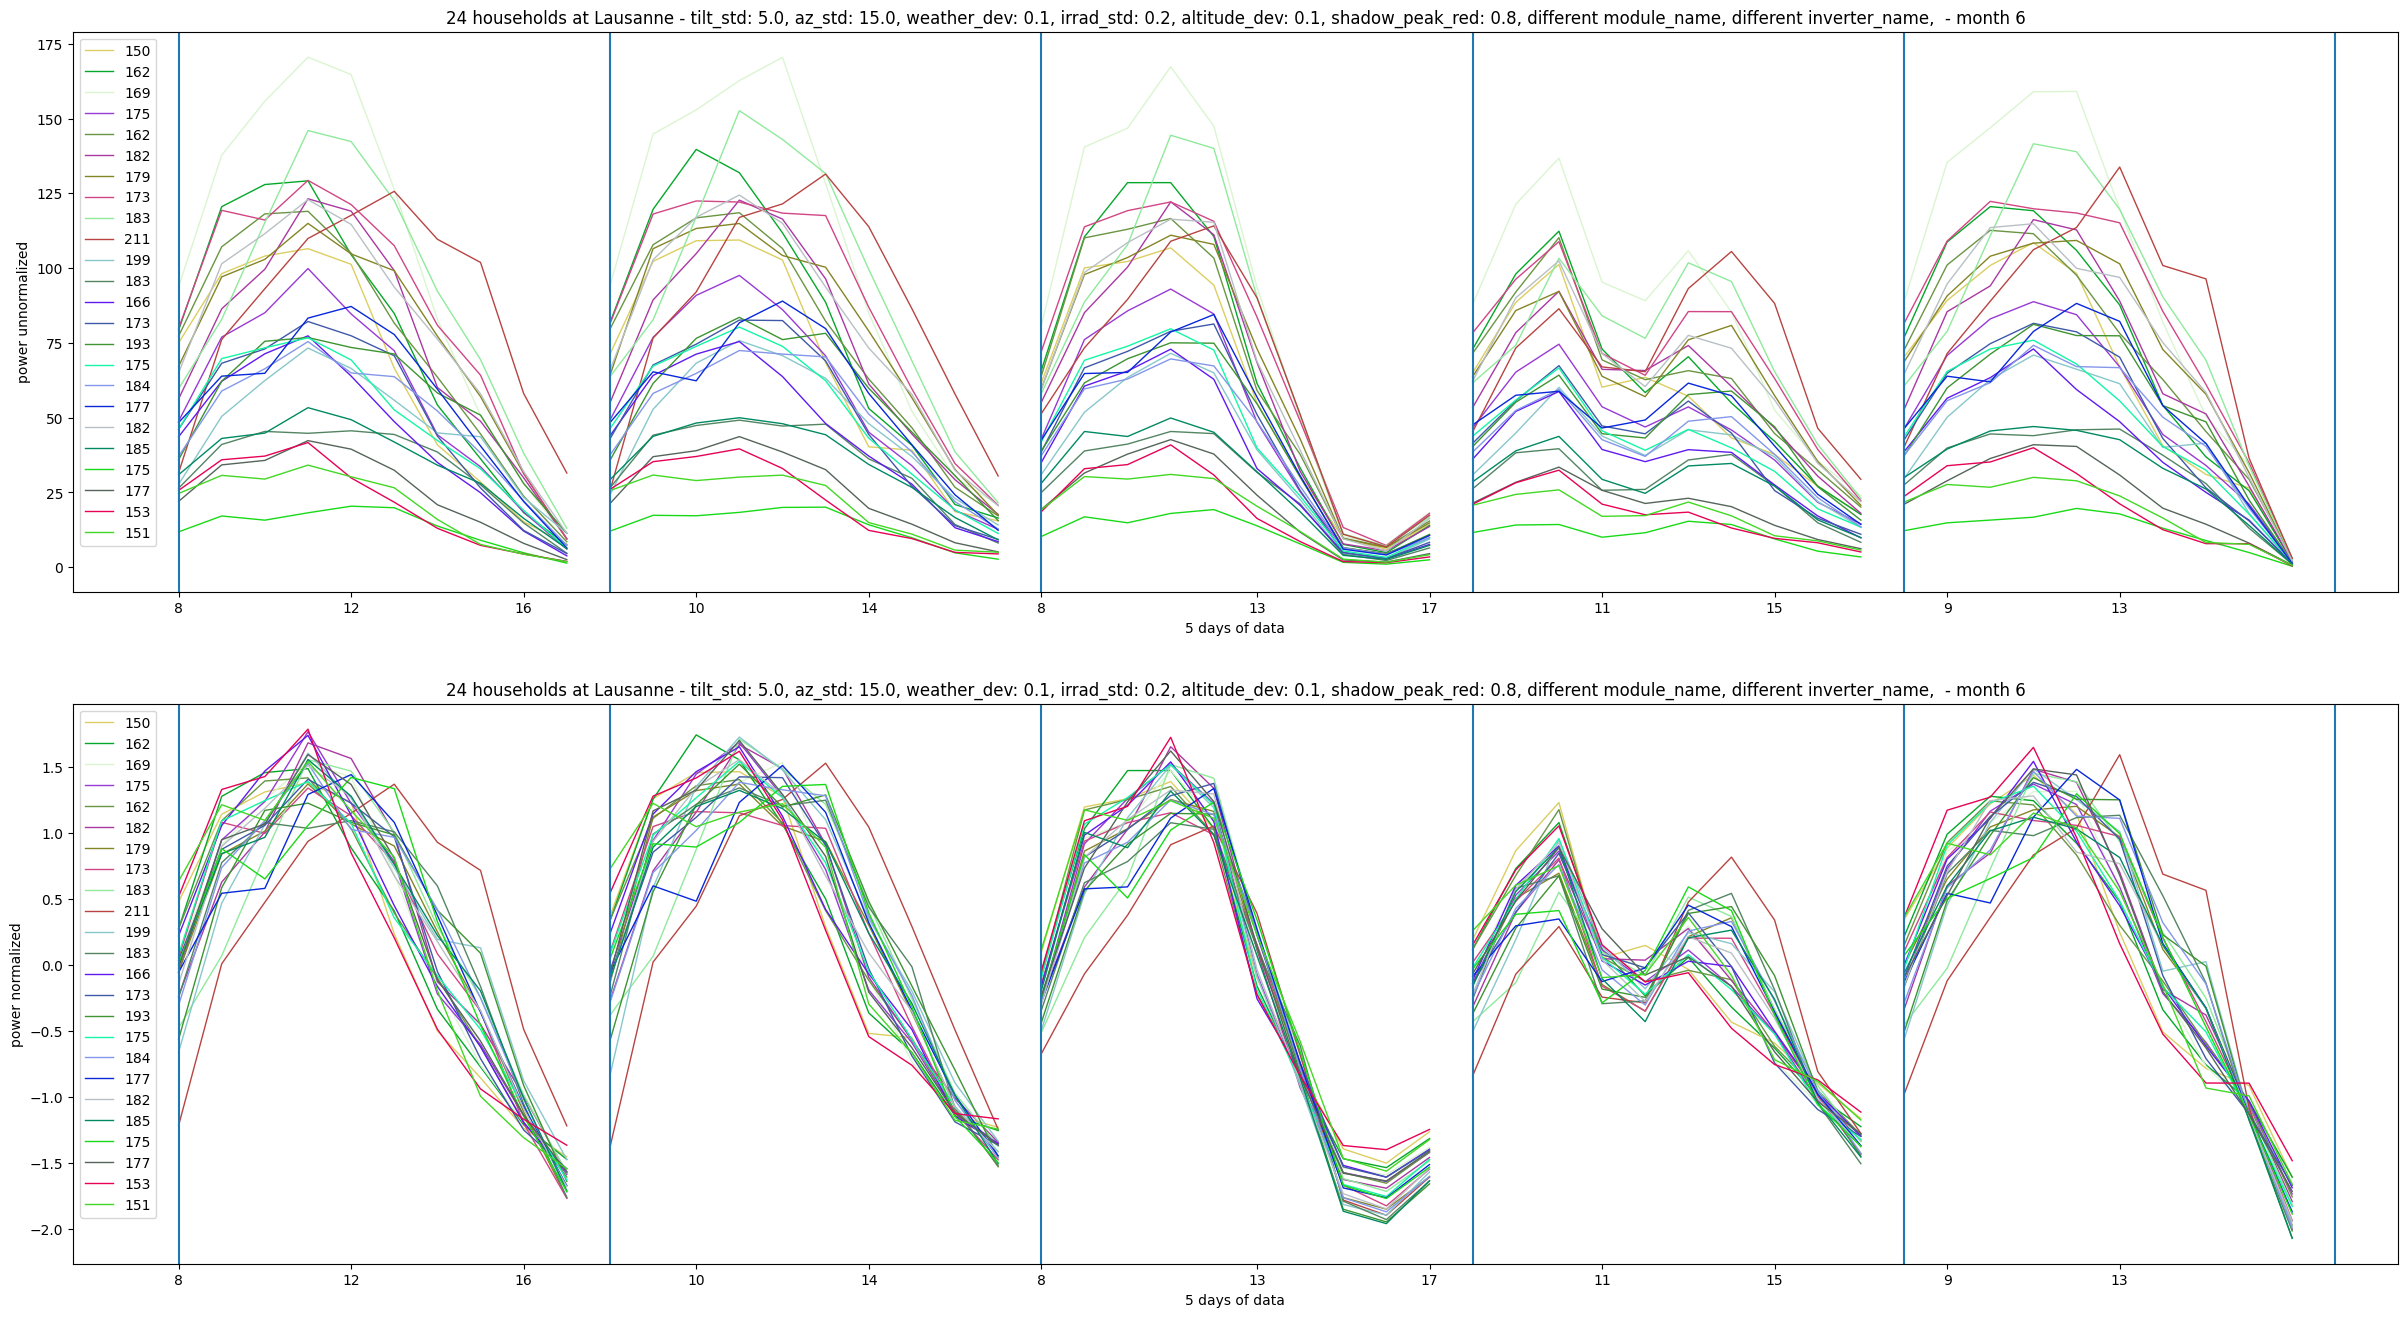

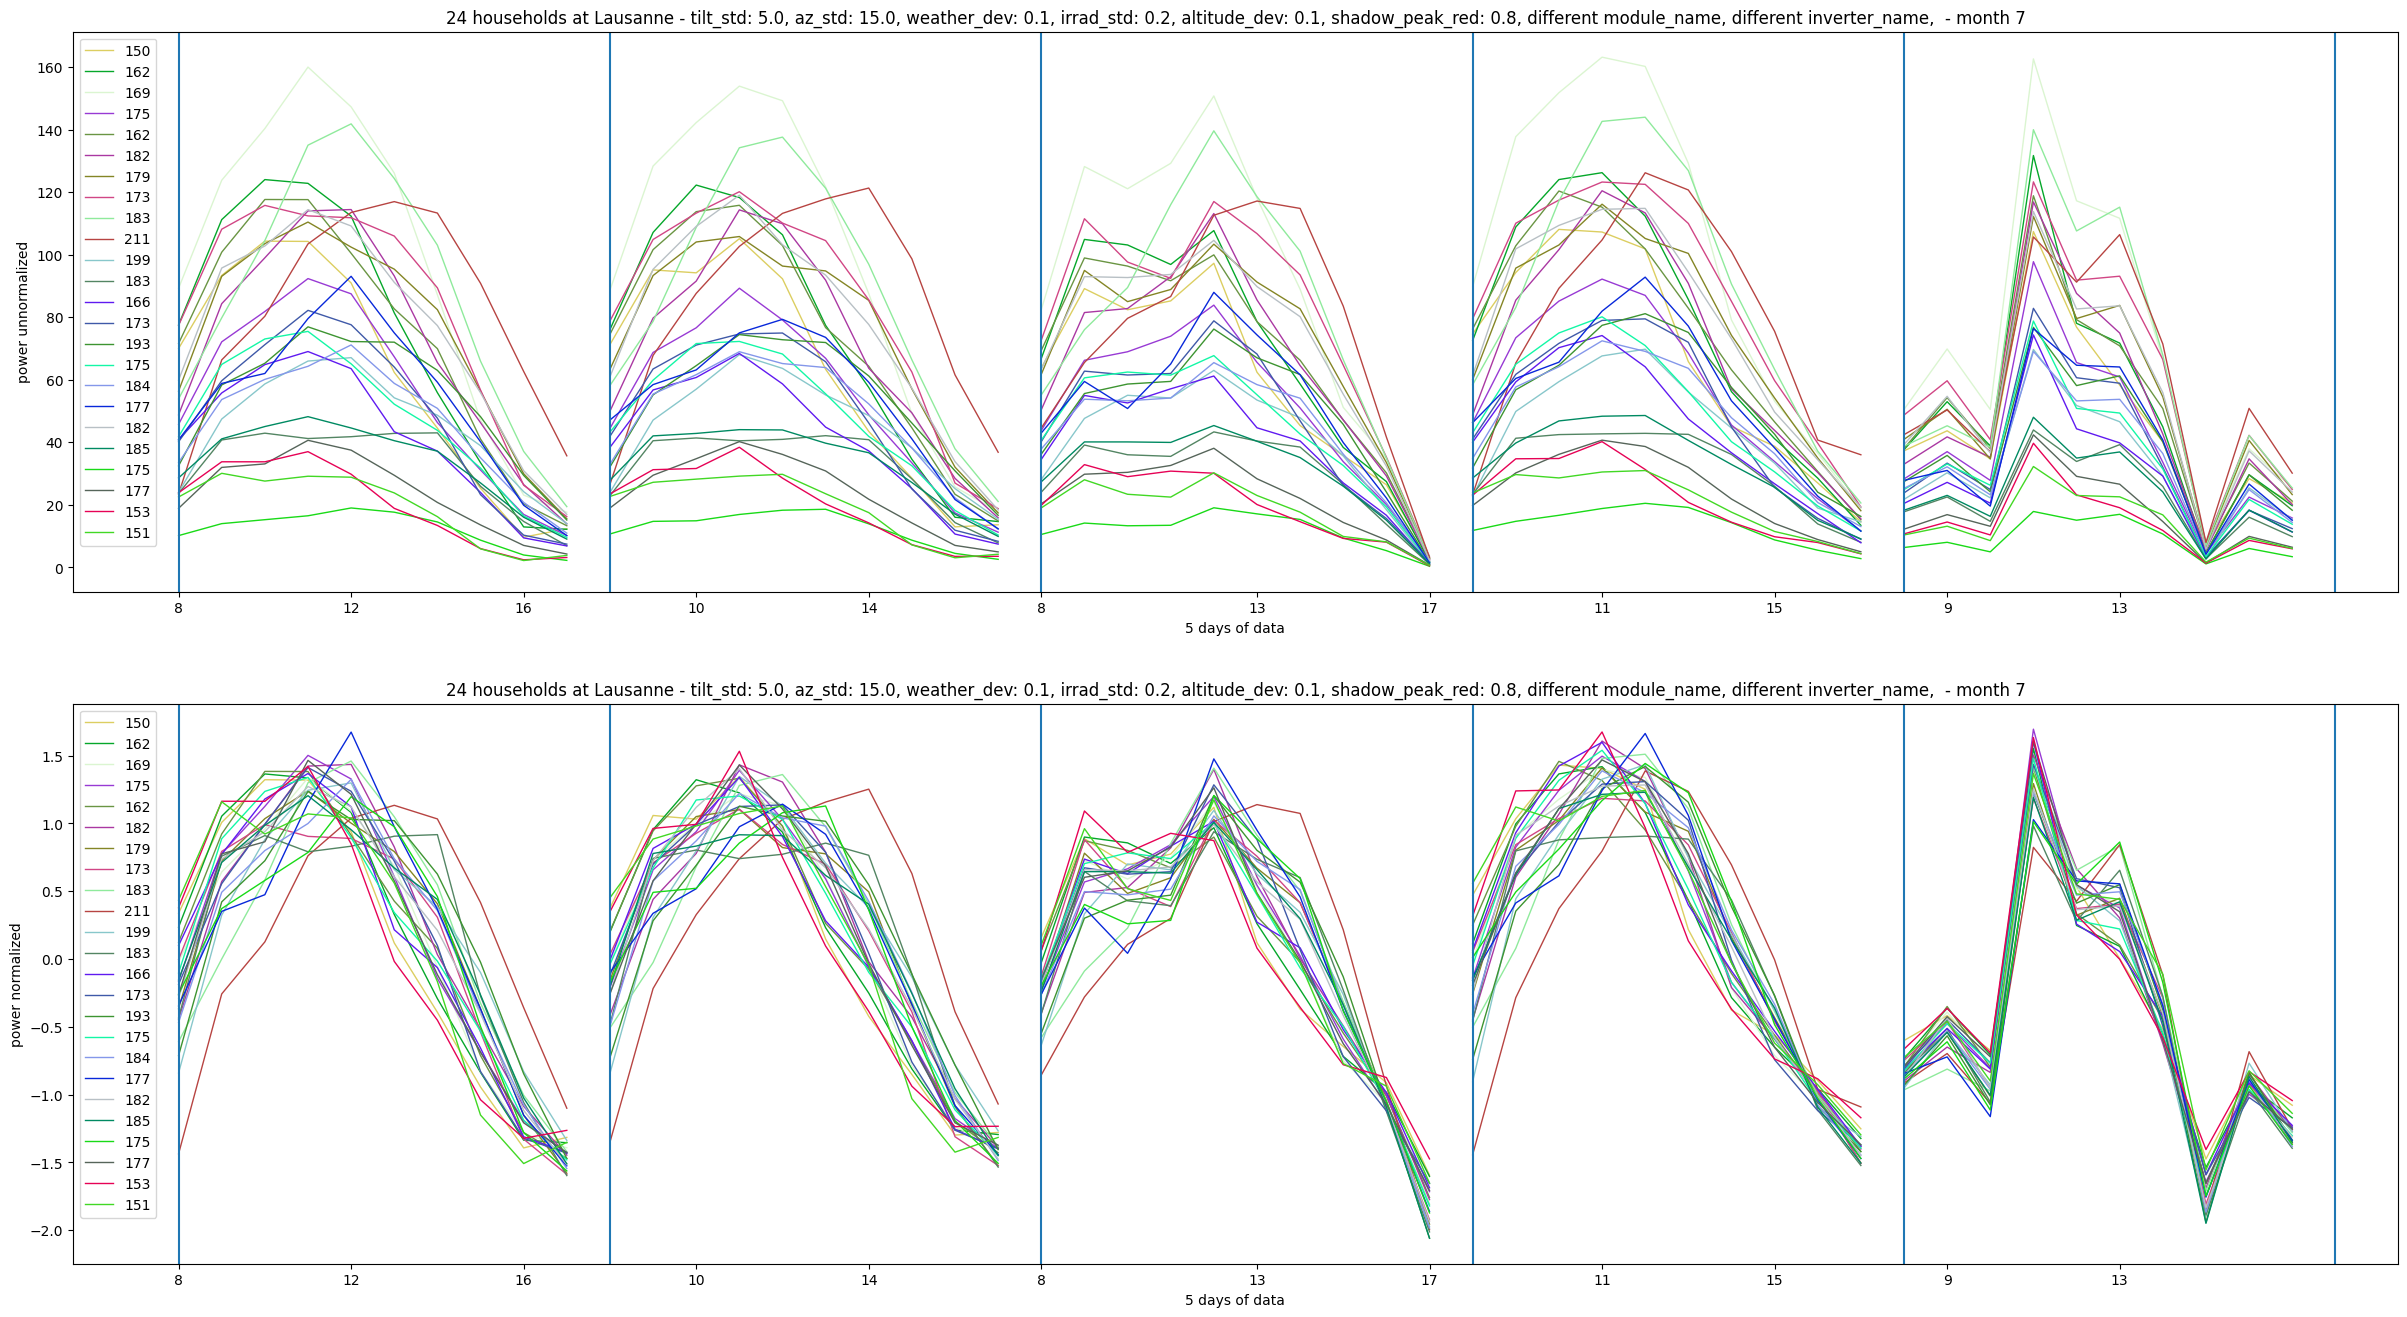

In [4]:
num_clients=24
city_names = ['Lausanne']

env_dict = {'city_names':city_names,
            'num_clients': num_clients, 'num_modes': len(city_names),
            'tilt_std': 5, 'az_std':15, 'weather_dev':0.1,
            'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':0.8,
            'module_name': get_available_modules('sandia')[0:num_clients],
            'inverter_name': get_available_inverters('cec')[0:num_clients],
            'lags':[], 'months':[6, 7], 'hours':np.arange(8, 18),
            'use_station_irrad_direct':True, 'use_station_irrad_diffuse':True,
            'delay_irrad':True, 'remove_constant_cols':True, 
            'train_scenarios':{'sml':{'m_train':150, 'train_years':[2018], 'valid_years':2019},
                            '1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019},
                            '5y':{'m_train':None, 'train_years':np.arange(2014, 2019), 'valid_years':2019},
                            '14y':{'m_train':None, 'train_years':np.arange(2005, 2019), 'valid_years':2019}}}

env_dict = PVDataset(env_dict).generate_clients_data(shuffle=False)

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
visualize_env(env_dict, num_days=5, year=2018, scenario_name='1y')

In [5]:
save_env=True
load_env=False
exp_name = 'PV_UniModal'
filename_env = os.getcwd() + "/../../saved_results/" + exp_name + "_env_raw"

# save data (there is nso file add the name of the file to the name of the folder)

if save_env:
    # save env
    file = open(filename_env, 'wb')
    pickle.dump(env_dict, file)
    msg = '[INFO] saved data for {:2.0f} clients'.format(env_dict['num_clients'])
elif load_env:
    file = open(filename_env, 'rb')
    env_dict = pickle.load(file)
    msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])
print(msg)
file.close()
print('\n'+env_dict['info'])

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\hecma\\OneDrive - epfl.ch\\Github repos\\Synthetic_PV_Profiles\\samples\\PV/../../saved_results/PV_UniModal_env_raw'